In [1]:
import threading
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


columns = ["Website",'test_name', 'HTTP status code', "Success", "Redirected to ISP Payload"]
df = pd.DataFrame(columns=columns)

text_file = "../../../BlockingLists/russianWebsites.txt"


cyta_payload = "This site can’t be reached due tο compliance the Council Regulation (EU) 350/2022 and with EU and National Laws, only for as long as necessary."


def find_payload(text):
   if cyta_payload in text:
       return True
   else: 
       return False

In [2]:
import requests
import socket
import ssl

html_file_with_results = "result.html"
txt_file_with_results = "result.txt"
logs_file = "result.log"


def write_to_file(filename, data):
    with open(filename, "w") as f:
        f.write("%s\n" % data)


def _decode_bytes(input_bytes):
    return input_bytes.decode(errors="replace")


def send_request(
        host, port, data, html_file, txt_file,
        fragment_size=0, fragment_count=0, is_https=True):
    sock = socket.create_connection((host, port), 10)
    if is_https:
        context = ssl.create_default_context()
        sock = context.wrap_socket(sock, server_hostname=host)

    if fragment_count:
        sock.setsockopt(socket.IPPROTO_TCP, socket.TCP_NODELAY, True)

    try:
        for fragment in range(fragment_count):
            write_to_file(html_file, "fragment" + str(fragment))
            write_to_file(txt_file, "fragment" + str(fragment))

            sock.sendall(data[:fragment_size].encode())
            data = data[fragment_size:]

            write_to_file(html_file, str(data))
            write_to_file(txt_file, str(data))

        sock.sendall(data.encode())
        recvdata = sock.recv(8192)
        recv = recvdata
        recv_decoded = recv.decode()
        # print(recv_decoded)
        while recvdata:
            recvdata = sock.recv(8192)
            recv += recvdata
    finally:
        try:
            sock.shutdown(socket.SHUT_RDWR)
        except  Exception:
            print("Exception occurred")
        sock.close()
    return _decode_bytes(recv)


def configure_request_body(host, urn="/"):
    requests_body = {
        "normal one ": {
            "data": "GET {} HTTP/1.1\r\n".format(urn)
                    + "Host: {}\r\nConnection: close\r\n\r\n".format(host),
            "fragment_size": 0,
            "fragment_count": 0,
        },
        "extra space after  GET": {
            "data": "GET  {} HTTP/1.0\r\n".format(urn)
                    + "Host: {}\r\nConnection: close\r\n\r\n".format(host),
            "fragment_size": 0,
            "fragment_count": 0,
        },
        "extra line break after GET": {
            "data": "\r\nGET {} HTTP/1.0\r\n".format(urn)
                    + "Host: {}\r\nConnection: close\r\n\r\n".format(host),
            "fragment_size": 0,
            "fragment_count": 0,
        },
        "tab sign after hostname": {
            "data": "GET {} HTTP/1.0\r\n".format(urn)
                    + "Host: {}\t\r\nConnection: close\r\n\r\n".format(host),
            "fragment_size": 0,
            "fragment_count": 0,
        },
        "fragmented header": {
            "data": "GET {} HTTP/1.0\r\n".format(urn)
                    + "Host: {}\r\nConnection: close\r\n\r\n".format(host),
            "fragment_size": 2,
            "fragment_count": 6,
        },
        "dot after hostname": {
            "data": "GET {} HTTP/1.0\r\n".format(urn)
                    + "Host: {}.\r\nConnection: close\r\n\r\n".format(host),
            "fragment_size": 0,
            "fragment_count": 0,
        },
        " hoSt instead Host": {
            "data": "GET {} HTTP/1.0\r\n".format(urn)
                    + "hoSt: {}\r\nConnection: close\r\n\r\n".format(host),
            "fragment_size": 0,
            "fragment_count": 0,
        },
        " hOSt instead Host": {
            "data": "GET {} HTTP/1.0\r\n".format(urn)
                    + "hOSt: {}\r\nConnection: close\r\n\r\n".format(host),
            "fragment_size": 0,
            "fragment_count": 0,
        },
        " Hostname with uppercase": {
            "data": "GET {} HTTP/1.0\r\n".format(urn)
                    + "Host: {}\r\nConnection: close\r\n\r\n".format(host.upper()),
            "fragment_size": 0,
            "fragment_count": 0,
        },
        "missing space sign after Host:": {
            "data": "GET {} HTTP/1.0\r\n".format(urn)
                    + "Host:{}\r\nConnection: close\r\n\r\n".format(host),
            "fragment_size": 0,
            "fragment_count": 0,
        },
        "unix style line break in header": {
            "data": "GET {} HTTP/1.0\n".format(urn)
                    + "Host: {}\nConnection: close\n\n".format(host),
            "fragment_size": 0,
            "fragment_count": 0,
        },
        "unusual order of connection and hostname": {
            "data": "GET {} HTTP/1.0\r\n".format(urn)
                    + "Connection: close\r\nHost: {}\r\n\r\n".format(host),
            "fragment_size": 0,
            "fragment_count": 0,
        },
        "fragmented header, hoSt and missed space": {
            "data": "GET {} HTTP/1.0\r\n".format(urn)
                    + "hoSt:{}\r\nConnection: close\r\n\r\n".format(host),
            "fragment_size": 2,
            "fragment_count": 6,
        },
    }
    return requests_body


def test_dpi(site, port, html_file=html_file_with_results,
             txt_file=txt_file_with_results, is_https=False):
    results = []
    configured_requests = configure_request_body(site, "/")
    for test_name in sorted(configured_requests):
        test = configured_requests[test_name]
        try:
            result = send_request(
                site,
                port,
                test.get("data"),
                html_file,
                txt_file,
                test.get("fragment_size"),
                test.get("fragment_count"),
                is_https,
            )
            df.loc[len(df)] = {
                "Website": site,
                "test_name": test_name,
                "HTTP status code": result.split("\n")[0],
                "Success": result.split("\n")[0].find("200 ") != -1,
                "Redirected to ISP Payload": find_payload(result)
            }
            df.reset_index(drop=True)
            
            # for i in range(len(result.split("\n"))):
            #     print(f"fdsfsdf: {i}", result.split("\n")[i])


        except Exception as e:
            print("🤬 error: ", repr(e))
        else:
            if result.split("\n")[0].find("200 ") != -1:
                print("😘 open successfully")
                results.append((test_name,result))
            else:
                print("😒 can't open")
    return list(set(results))


def trucate_https(domain):
    domain = domain.replace("https://", "")
    domain = domain.replace("http://", "")
    domain = domain.replace("www.", "")
    if domain.endswith("/"):
        domain = domain[:-1]
    return domain


def get_redirection(url, timeout=3):
    try:
            response = requests.get(f"http://{url}", allow_redirects=False, timeout=timeout)
    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")
        return None, False, type(e).__name__

    max_redirects = 10
    num_redirects = 0
    redirect_url = f"http://{url}"
    is_https = False
    while response.is_redirect or response.is_permanent_redirect:
        if num_redirects >= max_redirects:
            print("Reached maximum number of redirects.")
            break

        redirect_url = response.headers['Location']
        if redirect_url.find("https") != -1:
            is_https = True
        print(f"Redirecting to: {redirect_url}")
        try:
            response = requests.get(redirect_url, allow_redirects=False, timeout=timeout)
        except requests.exceptions.RequestException as e:
            print(f"An error occurred: {e}")
            return None, False, type(e).__name__
        num_redirects += 1
    redirect_url = trucate_https(redirect_url)
    print(redirect_url)
    return redirect_url, is_https


def test_http_or_https(site):
    site, is_https_required = get_redirection(site)
    if is_https_required:
        port = 443
    else:
        port = 80
    return test_dpi(site, port=port, is_https=is_https_required)




In [3]:

def parse_http_response(response_text):
    headers = {}
    lines = response_text.split('\n')
    status_line = lines[0].strip()
    headers['HTTP Status'] = status_line

    for line in lines[1:]:
        line = line.strip()
        if not line:
            break
        if ':' in line:
            key, value = line.split(':', 1)
            headers[key.strip()] = value.strip()
        else:
            headers[line] = None

    return headers


def test_sites_from_file(filename):
    with open(filename, "r") as file:
        websites = [line.strip() for line in file]

    threads = []
    for site in websites:
        thread = threading.Thread(target=process_site, args=(site,))
        thread.start()
        threads.append(thread)
    for thread in threads:
        thread.join()


def process_site(site):
    test_http_or_https(site)


test_sites_from_file(text_file)     

Redirecting to: https://russian.rt.com/
Redirecting to: https://vk.com/
Redirecting to: https://iz.ru/
Redirecting to: https://svpressa.ru/
Redirecting to: https://lenta.ru/
Redirecting to: https://gosuslugi.ru/
Redirecting to: https://regnum.ru/
Redirecting to: https://vz.ru/
Redirecting to: https://www.rt.ru/
Redirecting to: https://admburla.ru/
Redirecting to: https://www.nalog.gov.ru/
aeroflot.ru
Redirecting to: https://voskhod.ru/
😒 can't open
iz.ru
Redirecting to: https://m.vk.com/
gosuslugi.ru
Redirecting to: https://www.nalog.gov.ru/rn77/
svpressa.ru


Exception in thread Thread-18 (process_site):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/dmitrii/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_13907/3164626645.py", line 34, in process_site
  File "/tmp/ipykernel_13907/2998507409.py", line 224, in test_http_or_https
ValueError: too many values to unpack (expected 2)


An error occurred: HTTPSConnectionPool(host='admburla.ru', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate in certificate chain (_ssl.c:1007)')))
russian.rt.com
rt.ru
Redirecting to: https://rt.com/
😒 can't open
vz.ru
lenta.ru
regnum.ru
😒 can't open
nalog.gov.ru/rn77
🤬 error:  gaierror(-2, 'Name or service not known')
🤬 error:  gaierror(-2, 'Name or service not known')
🤬 error:  gaierror(-2, 'Name or service not known')
🤬 error:  gaierror(-2, 'Name or service not known')
🤬 error:  gaierror(-2, 'Name or service not known')
🤬 error:  gaierror(-2, 'Name or service not known')
🤬 error:  gaierror(-2, 'Name or service not known')
🤬 error:  gaierror(-2, 'Name or service not known')
🤬 error:  gaierror(-2, 'Name or service not known')
🤬 error:  gaierror(-2, 'Name or service not known')
🤬 error:  gaierror(-2, 'Name or service not known')
🤬 error:  gaierror(-2, 'Name or

Exception in thread Thread-7 (process_site):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/dmitrii/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_13907/3164626645.py", line 34, in process_site
  File "/tmp/ipykernel_13907/2998507409.py", line 224, in test_http_or_https
ValueError: too many values to unpack (expected 2)
Exception in thread Thread-10 (process_site):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/dmitrii/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*s

😒 can't open
😘 open successfully
An error occurred: HTTPConnectionPool(host='ria.ru', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x7f6630e7f370>, 'Connection to ria.ru timed out. (connect timeout=3)'))
😒 can't open
An error occurred: HTTPConnectionPool(host='tass.ru', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x7f6630e7c4c0>, 'Connection to tass.ru timed out. (connect timeout=3)'))


Exception in thread Thread-13 (process_site):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/dmitrii/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_13907/3164626645.py", line 34, in process_site
  File "/tmp/ipykernel_13907/2998507409.py", line 224, in test_http_or_https
ValueError: too many values to unpack (expected 2)
Exception in thread Thread-19 (process_site):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/dmitrii/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
Exception in thread Thread-20 (process_site):
Traceback (most recent call last):
  File "/usr/lib/python3.10/t

An error occurred: HTTPConnectionPool(host='vesti.ru', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x7f6630e70160>, 'Connection to vesti.ru timed out. (connect timeout=3)'))
An error occurred: HTTPConnectionPool(host='rosguard.gov.ru', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x7f662c5a0250>, 'Connection to rosguard.gov.ru timed out. (connect timeout=3)'))
An error occurred: HTTPConnectionPool(host='mos.ru', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x7f6630717e80>, 'Connection to mos.ru timed out. (connect timeout=3)'))
😘 open successfully
😘 open successfully
😒 can't open
😘 open successfully
😒 can't open
😒 can't open
😘 open successfully
😘 open successfully
😘 open successfully
😒 can't open
😘 open successfully
😒 can't open
😒 can't open
😘 open successfully
😒 can

Exception in thread Thread-17 (process_site):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/dmitrii/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_13907/3164626645.py", line 34, in process_site
  File "/tmp/ipykernel_13907/2998507409.py", line 224, in test_http_or_https
ValueError: too many values to unpack (expected 2)


😘 open successfully
😒 can't open
😒 can't open
An error occurred: HTTPConnectionPool(host='rg.ru', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x7f6630715f30>, 'Connection to rg.ru timed out. (connect timeout=3)'))
😒 can't open
😘 open successfully
😘 open successfully
😒 can't open
😘 open successfully
😘 open successfully
😒 can't open
😒 can't open
😒 can't open
😘 open successfully
😒 can't open
😘 open successfully
😘 open successfully
😒 can't open
😒 can't open
😒 can't open
😘 open successfully
😒 can't open
😘 open successfully
😘 open successfully
😒 can't open
😘 open successfully
😘 open successfully
😒 can't open
😒 can't open
😒 can't open
😘 open successfully
😘 open successfully
😒 can't open
😒 can't open
😘 open successfully
😘 open successfully
😘 open successfully
😘 open successfully
😘 open successfully
😘 open successfully
😒 can't open
😒 can't open
😘 open successfully
😒 can't open
😘 open successfully
😘 open successfully
😘 op

Exception in thread Thread-21 (process_site):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/dmitrii/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_13907/3164626645.py", line 34, in process_site
  File "/tmp/ipykernel_13907/2998507409.py", line 224, in test_http_or_https
ValueError: too many values to unpack (expected 2)


An error occurred: HTTPConnectionPool(host='pochta.ru', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x7f662c5a0df0>, 'Connection to pochta.ru timed out. (connect timeout=3)'))
😘 open successfully


In [4]:
df.head()

,Website,test_name,HTTP status code,Success,Redirected to ISP Payload
0,aeroflot.ru,Hostname with uppercase,HTTP/1.1 403 Forbidden\r,False,False
1,aeroflot.ru,hOSt instead Host,HTTP/1.1 403 Forbidden\r,False,False
2,iz.ru,Hostname with uppercase,HTTP/1.1 403 Forbidden\r,False,False
3,gosuslugi.ru,Hostname with uppercase,HTTP/1.1 200 OK\r,True,False
4,aeroflot.ru,hoSt instead Host,HTTP/1.1 403 Forbidden\r,False,False


) missing from current font.hon3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


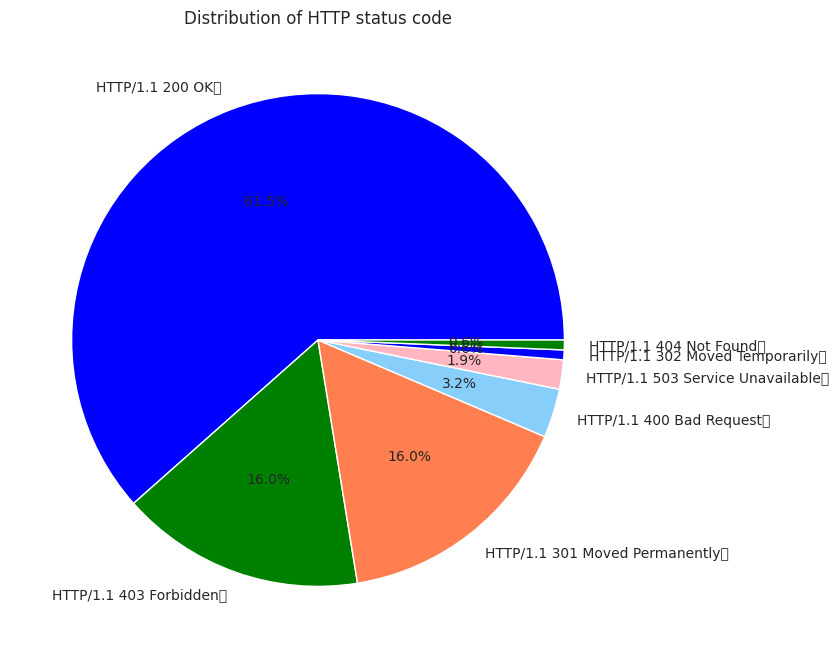

In [5]:
plt.figure(figsize=(8, 8))
df['HTTP status code'].value_counts().plot(kind='pie', autopct='%1.1f%%',  colors=['blue', 'green', 'coral', 'lightskyblue', 'lightpink'])
plt.title('Distribution of HTTP status code')
plt.ylabel('')
plt.show()



) missing from current font.370.py:12: UserWarning: Glyph 13 (
  plt.tight_layout()
) missing from current font.hon3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


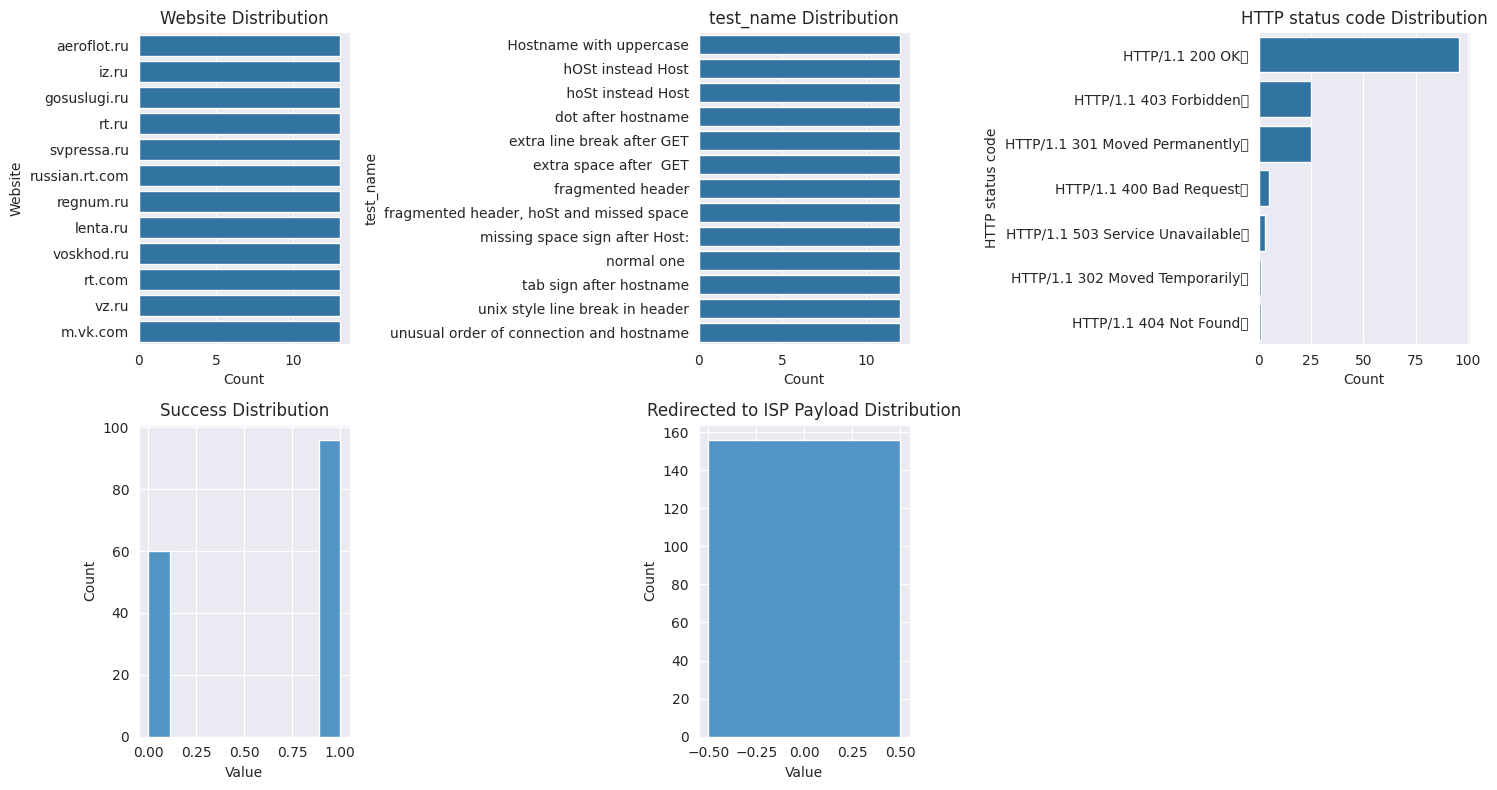

In [6]:
plt.figure(figsize=(15, 8))

for i, column in enumerate(df.columns):
    plt.subplot(2, 3, i+1)
    if df[column].dtype == 'object':
        sns.countplot(data=df, y=column, order=df[column].value_counts().index)
    else:
        sns.histplot(data=df, x=column)
    plt.title(f'{column} Distribution')
    plt.xlabel('Count' if df[column].dtype == 'object' else 'Value')

plt.tight_layout()
plt.show()

) missing from current font.064.py:18: UserWarning: Glyph 13 (
  plt.tight_layout()
) missing from current font.064.py:20: UserWarning: Glyph 13 (
  plt.savefig('http_status_code_distribution.png', dpi=300)
) missing from current font.hon3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


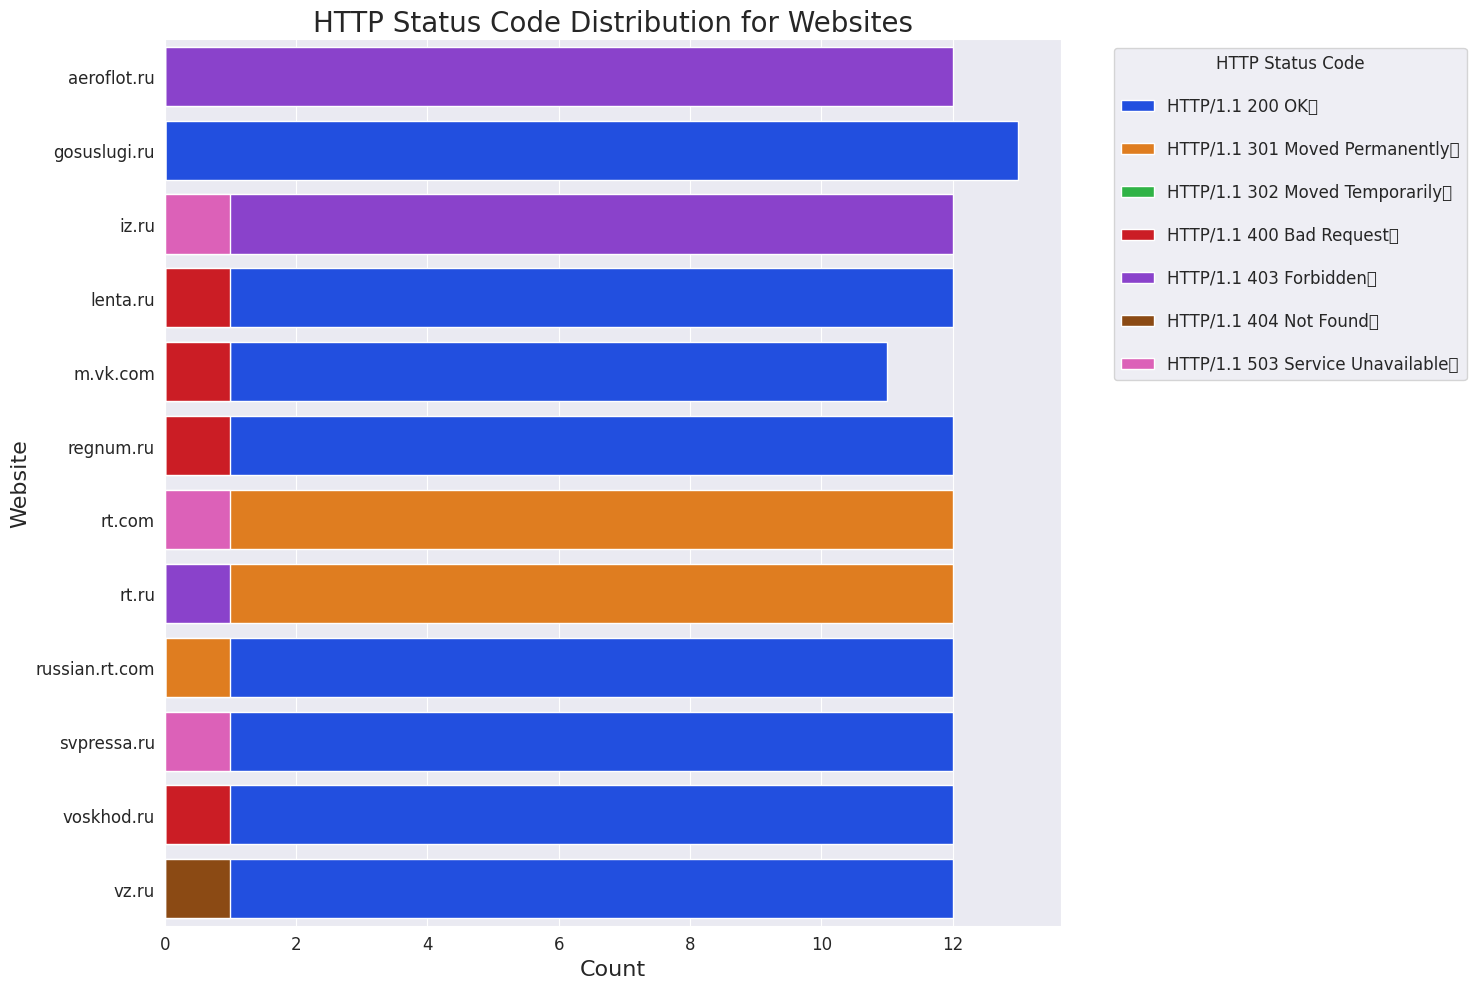

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

website_status_counts = df.groupby(['Website', 'HTTP status code']).size().unstack(fill_value=0)

colors = sns.color_palette('bright', len(website_status_counts.columns))

plt.figure(figsize=(15, 10))
for http_status_code, data, color in zip(website_status_counts.columns, website_status_counts.values.T, colors):
    sns.barplot(x=data, y=website_status_counts.index, color=color, label=http_status_code)

plt.title('HTTP Status Code Distribution for Websites', fontsize=20)
plt.xlabel('Count', fontsize=16)
plt.ylabel('Website', fontsize=16)
plt.legend(title='HTTP Status Code', title_fontsize='large', fontsize='large', bbox_to_anchor=(1.05, 1), loc='upper left', labelspacing=1.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.savefig('http_status_code_distribution.png', dpi=300)
plt.show()


) missing from current font.428.py:15: UserWarning: Glyph 13 (
  plt.tight_layout()
) missing from current font.hon3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


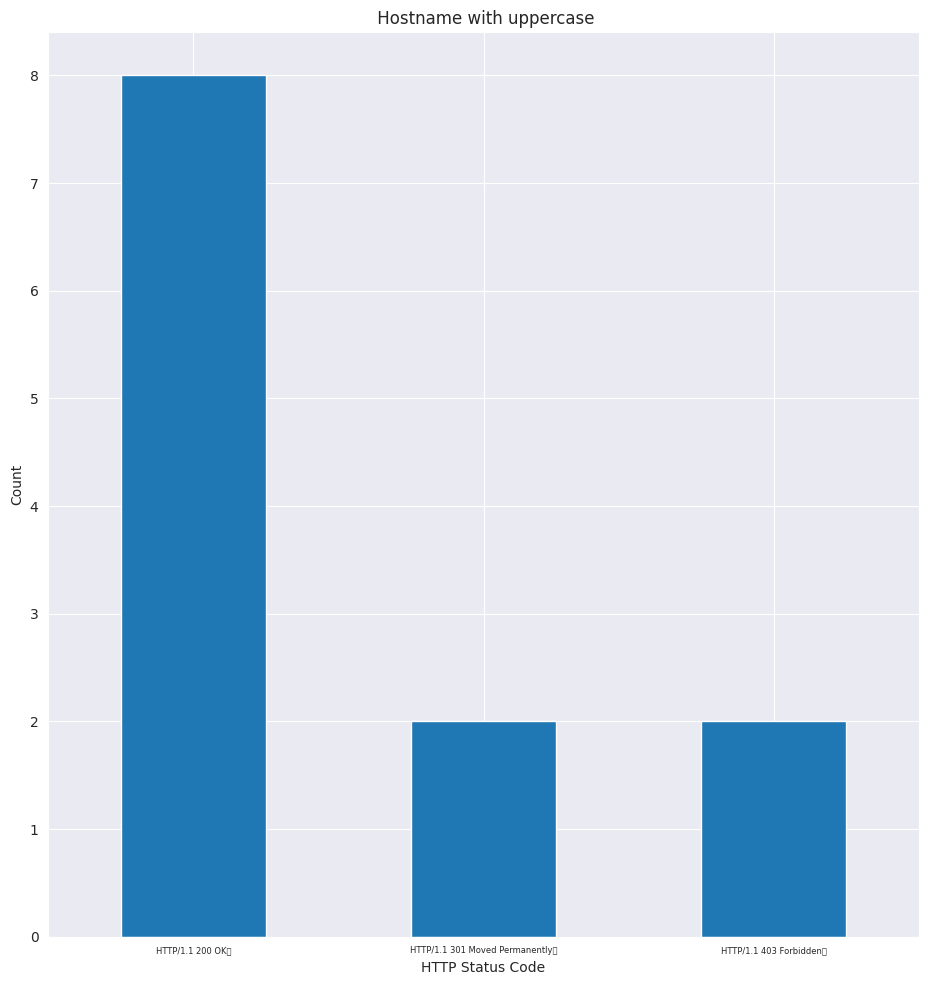

) missing from current font.428.py:15: UserWarning: Glyph 13 (
  plt.tight_layout()
) missing from current font.hon3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


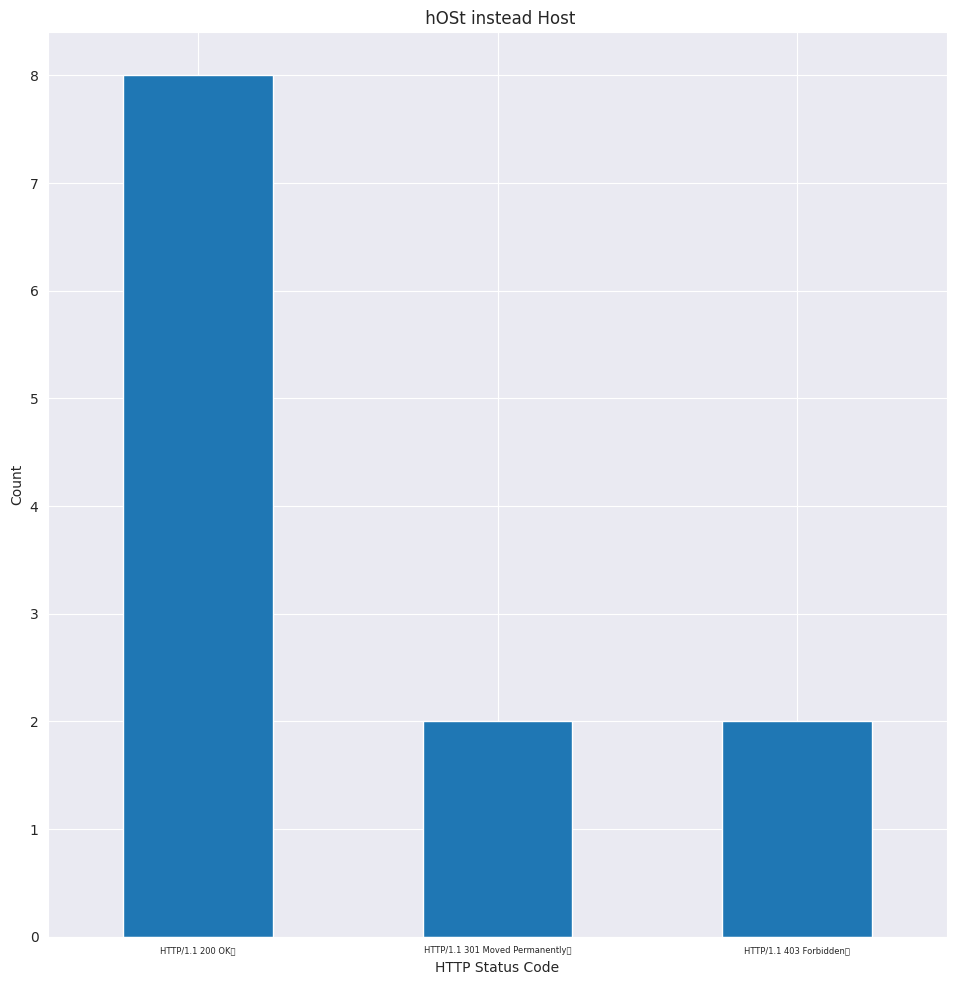

) missing from current font.428.py:15: UserWarning: Glyph 13 (
  plt.tight_layout()
) missing from current font.hon3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


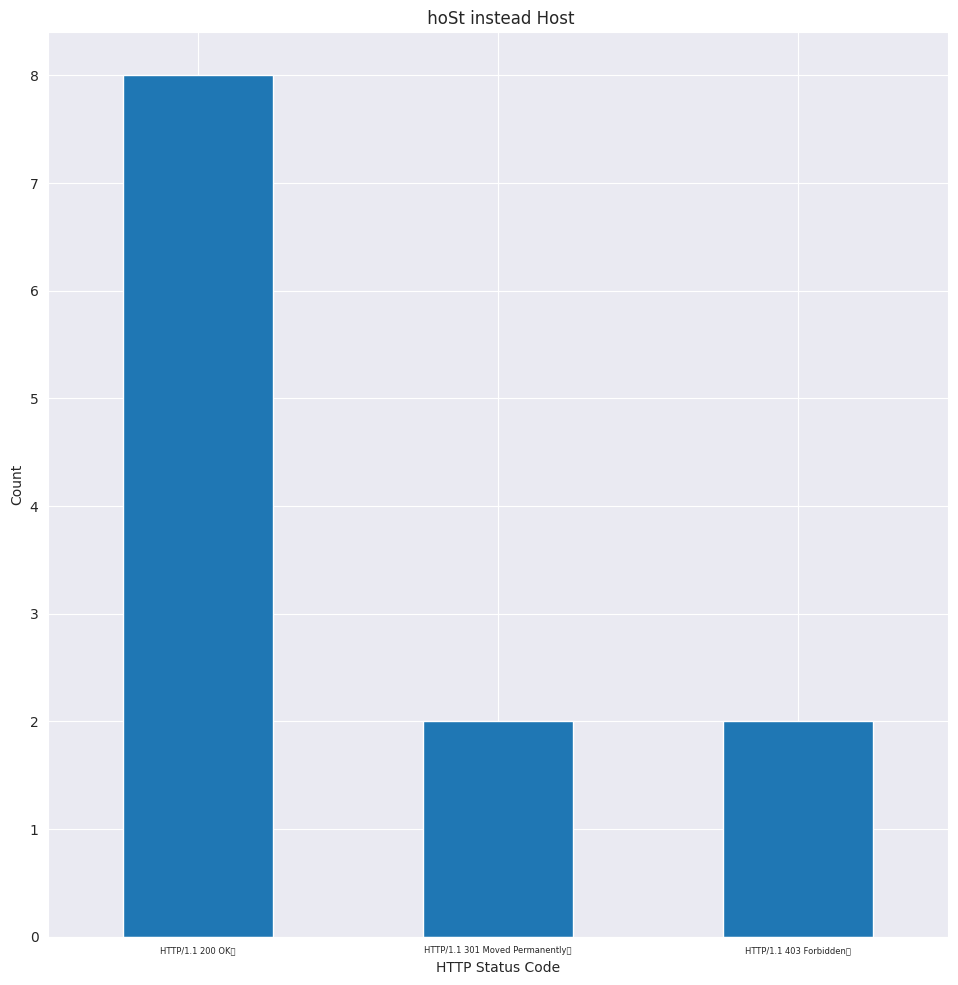

) missing from current font.428.py:15: UserWarning: Glyph 13 (
  plt.tight_layout()
) missing from current font.hon3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


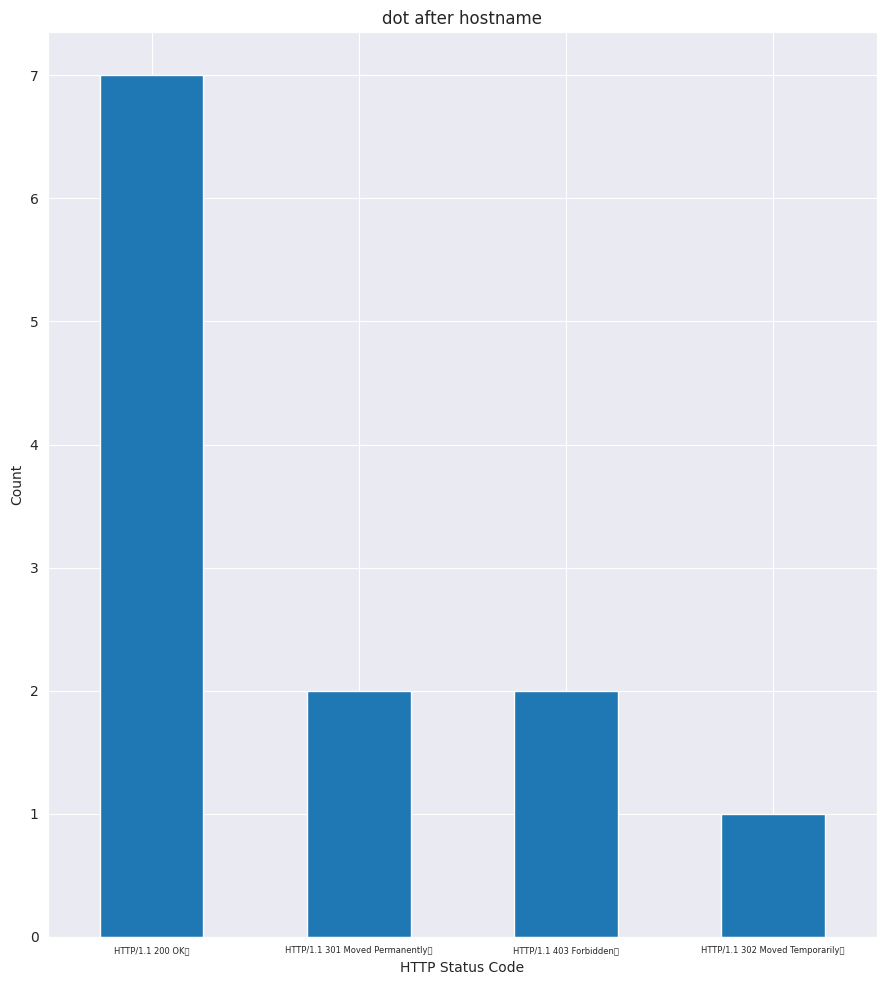

) missing from current font.428.py:15: UserWarning: Glyph 13 (
  plt.tight_layout()
) missing from current font.hon3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


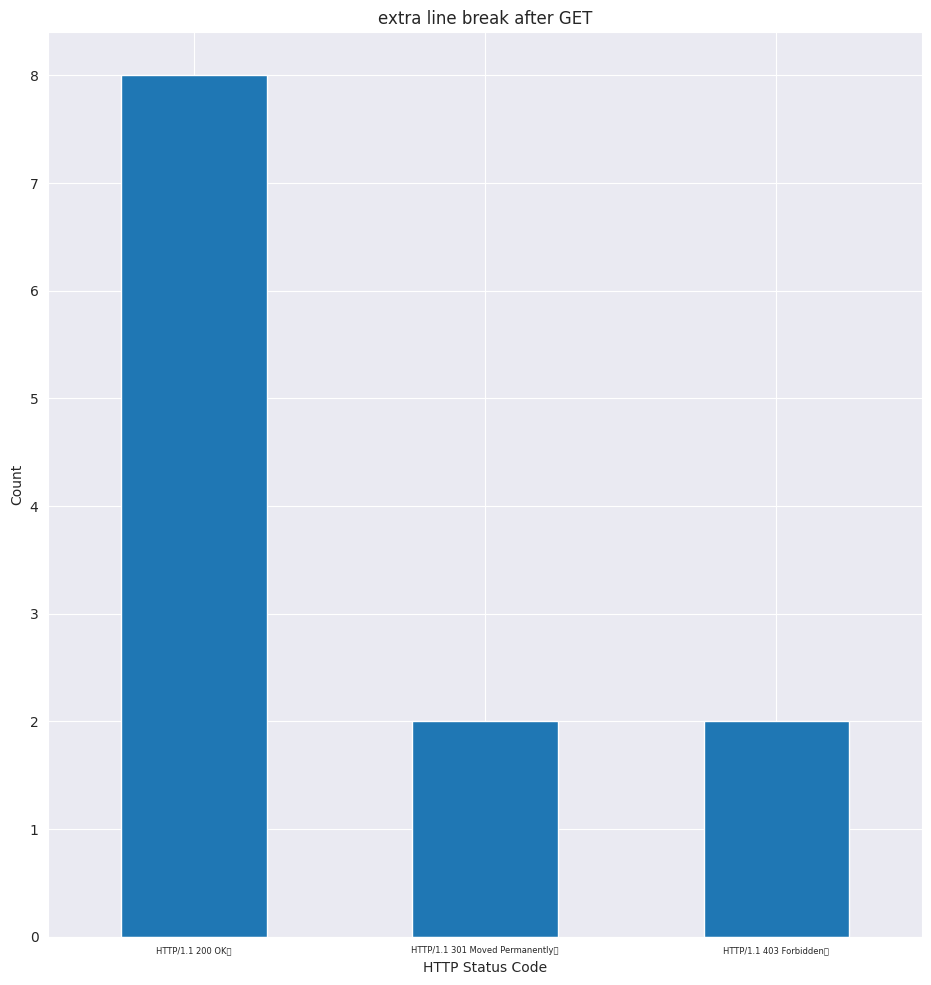

) missing from current font.428.py:15: UserWarning: Glyph 13 (
  plt.tight_layout()
) missing from current font.hon3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


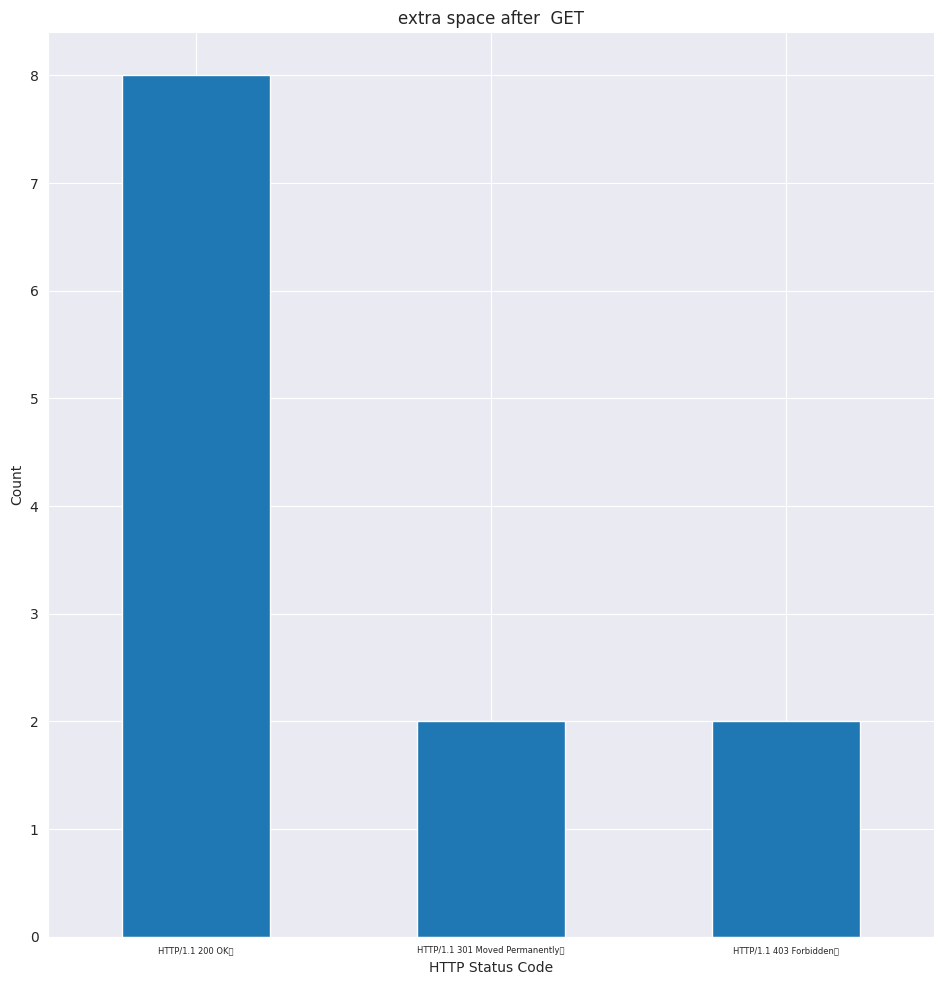

) missing from current font.428.py:15: UserWarning: Glyph 13 (
  plt.tight_layout()
) missing from current font.hon3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


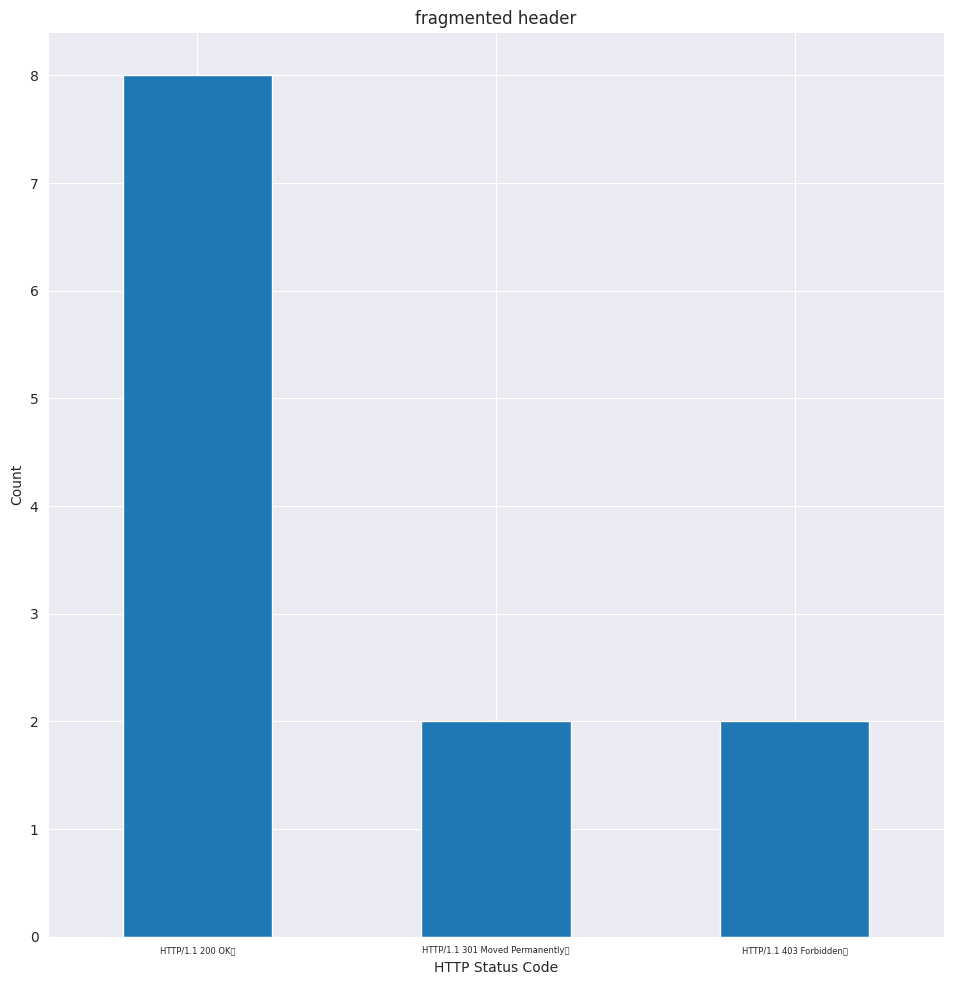

) missing from current font.428.py:15: UserWarning: Glyph 13 (
  plt.tight_layout()
) missing from current font.hon3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


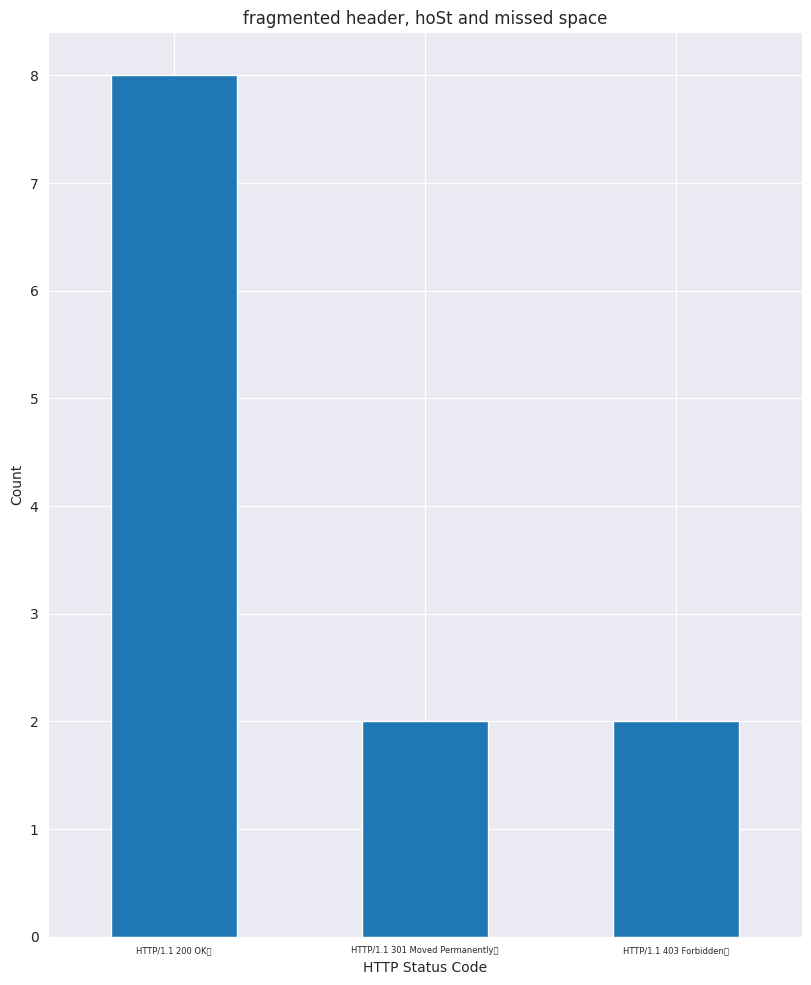

) missing from current font.428.py:15: UserWarning: Glyph 13 (
  plt.tight_layout()
) missing from current font.hon3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


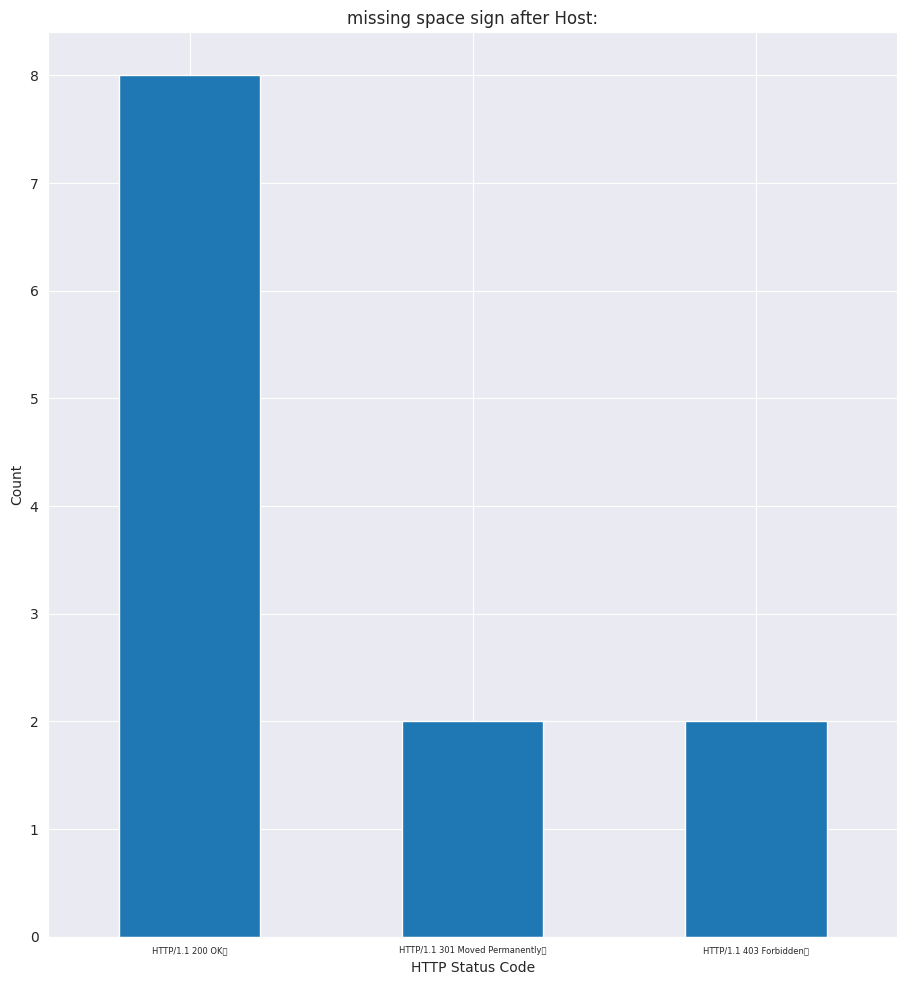

) missing from current font.428.py:15: UserWarning: Glyph 13 (
  plt.tight_layout()
) missing from current font.hon3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


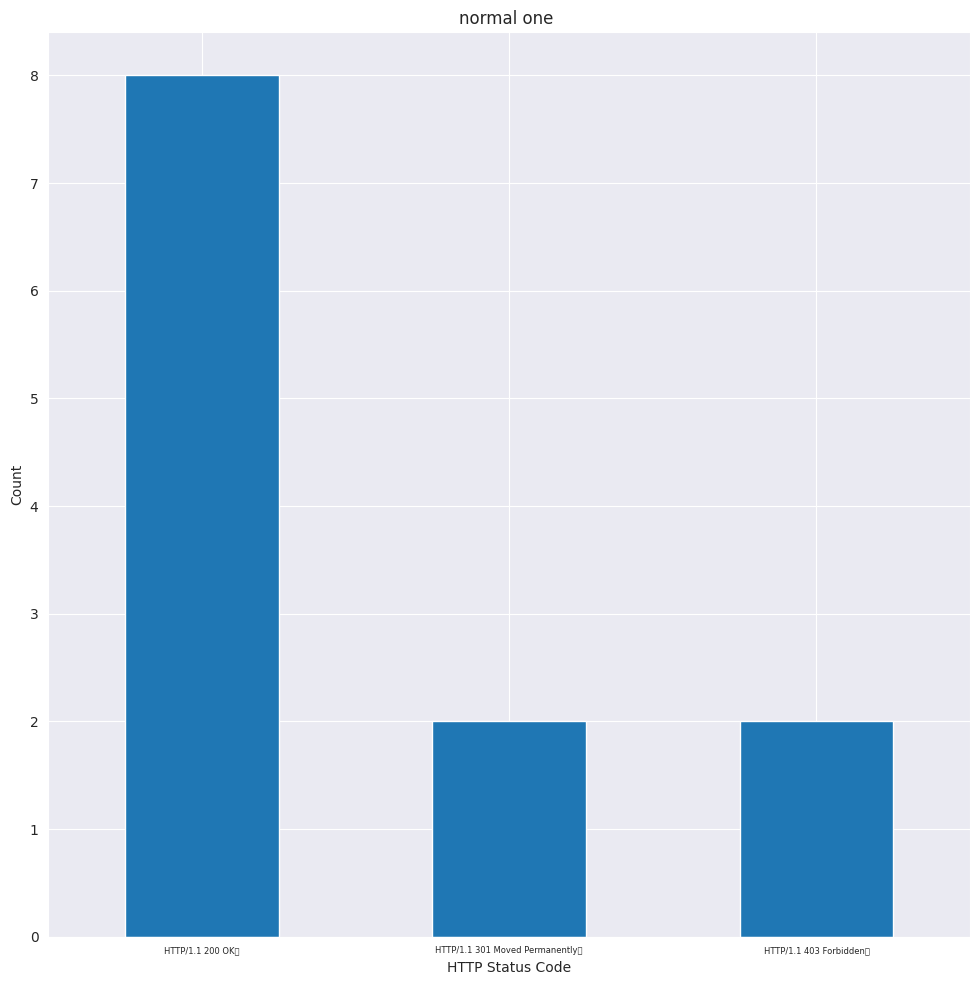

) missing from current font.428.py:15: UserWarning: Glyph 13 (
  plt.tight_layout()
) missing from current font.hon3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


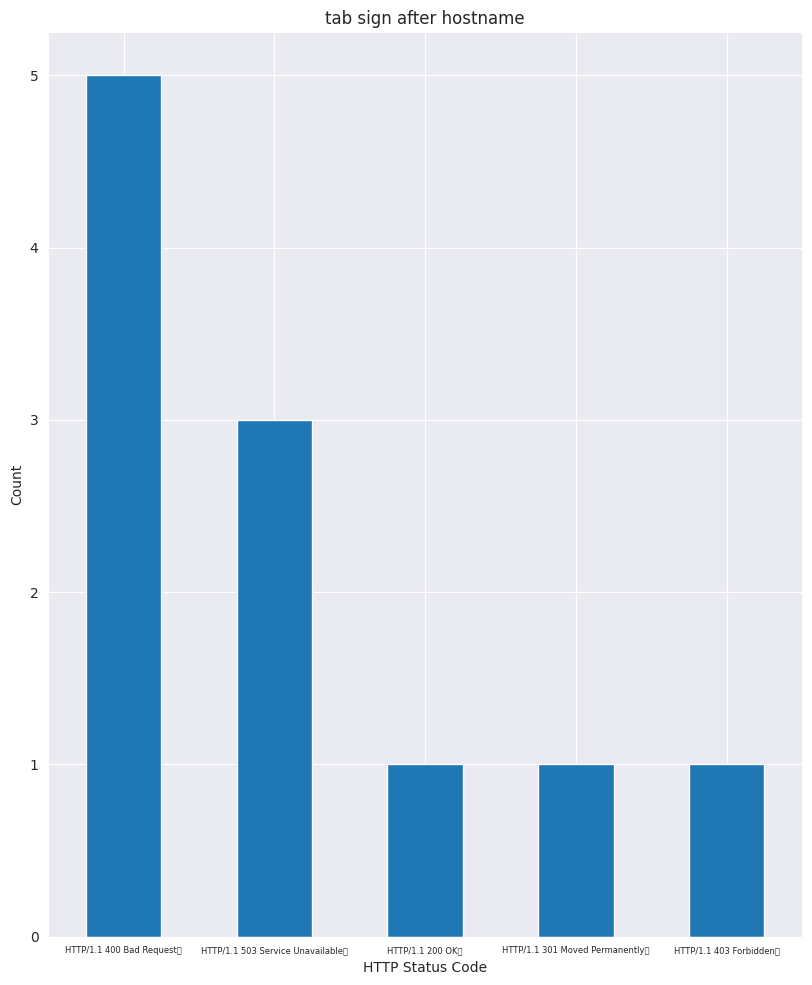

) missing from current font.428.py:15: UserWarning: Glyph 13 (
  plt.tight_layout()
) missing from current font.hon3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


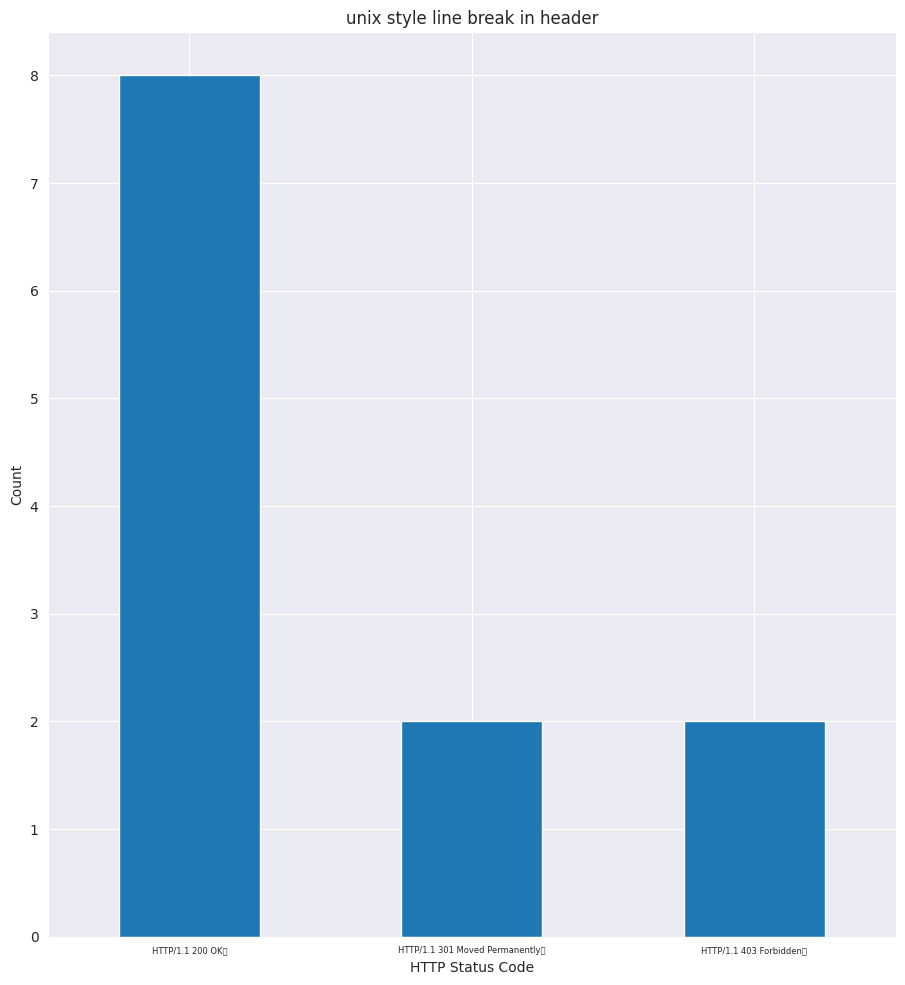

) missing from current font.428.py:15: UserWarning: Glyph 13 (
  plt.tight_layout()
) missing from current font.hon3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


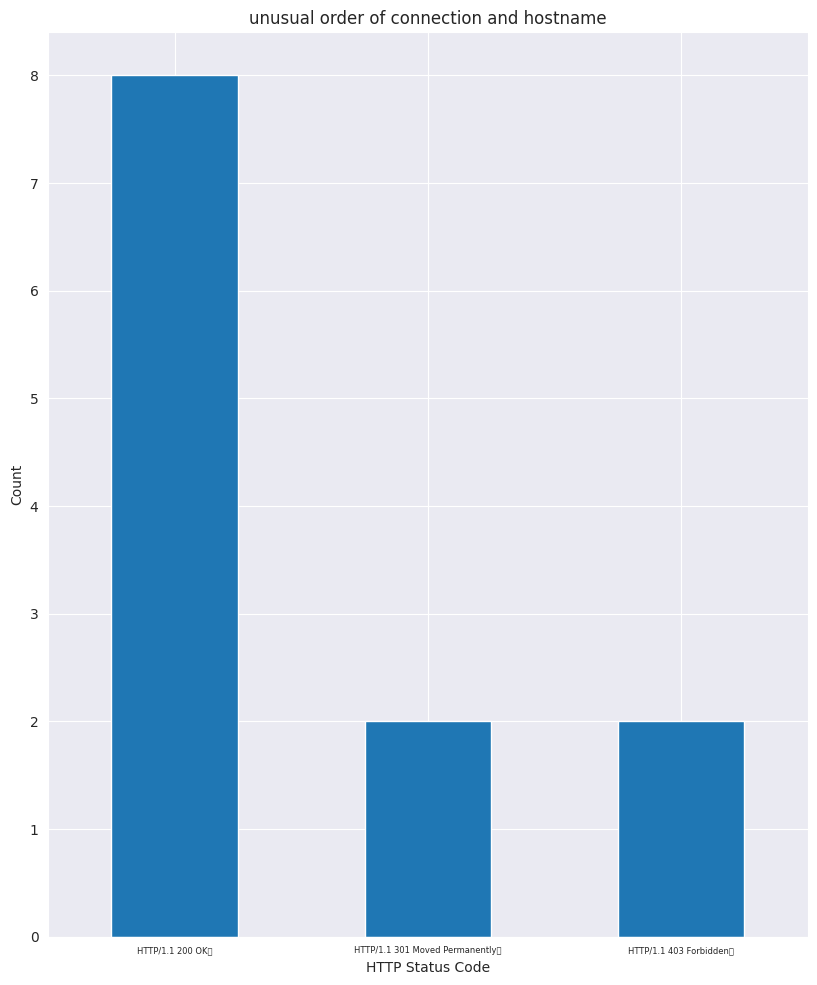

In [8]:
grouped_test_names = df.groupby('test_name')['HTTP status code'].value_counts()
top5_status_codes_names = grouped_test_names.groupby(level=0).nlargest(5).reset_index(level=0, drop=True)

num_tests = len(top5_status_codes_names.index.unique())
rows = (num_tests + 2) // 3
cols = min(num_tests, 3)

for i, (test_name, data) in enumerate(top5_status_codes_names.groupby(level=0)):
    plt.figure(figsize=(10, 10))
    ax = data.plot(kind='bar', legend=False)
    plt.title(f'{test_name}')
    plt.ylabel('Count')
    plt.xticks(rotation=360)
    plt.xlabel('HTTP Status Code')
    plt.tight_layout()
    labels = [f'{code}' for code, description in zip(data.index.get_level_values(1), ['Ok', 'Not Found', 'Redirect', 'Server Error', 'Other'])]
    ax.set_xticklabels(labels, fontsize=6)

    plt.show()

) missing from current font.hon3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


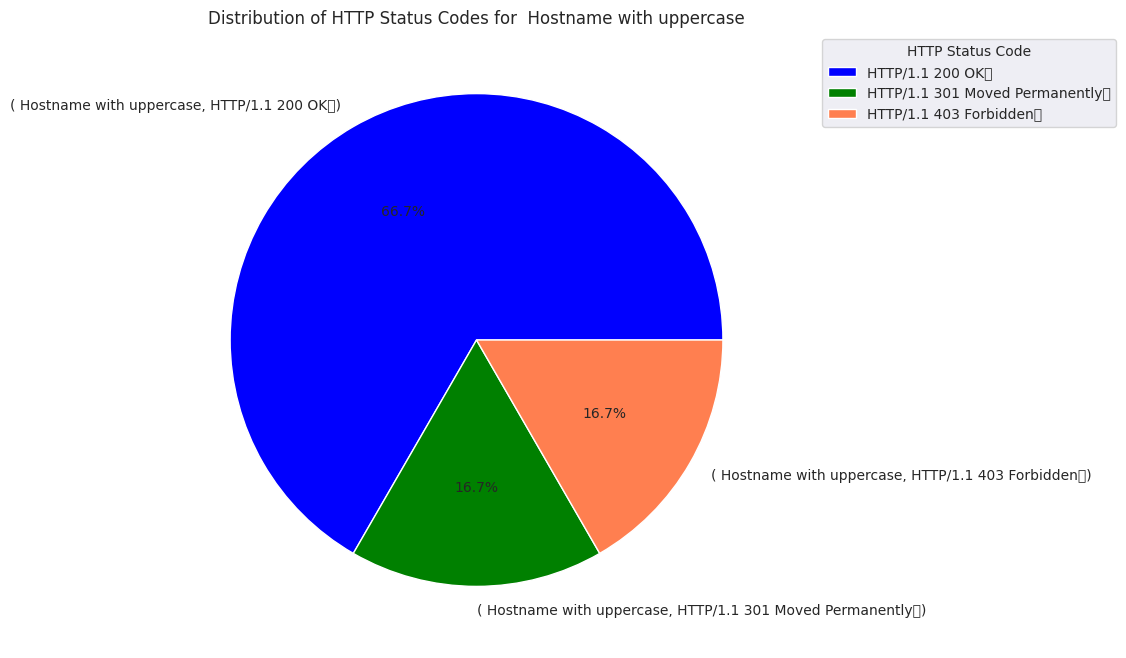

) missing from current font.hon3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


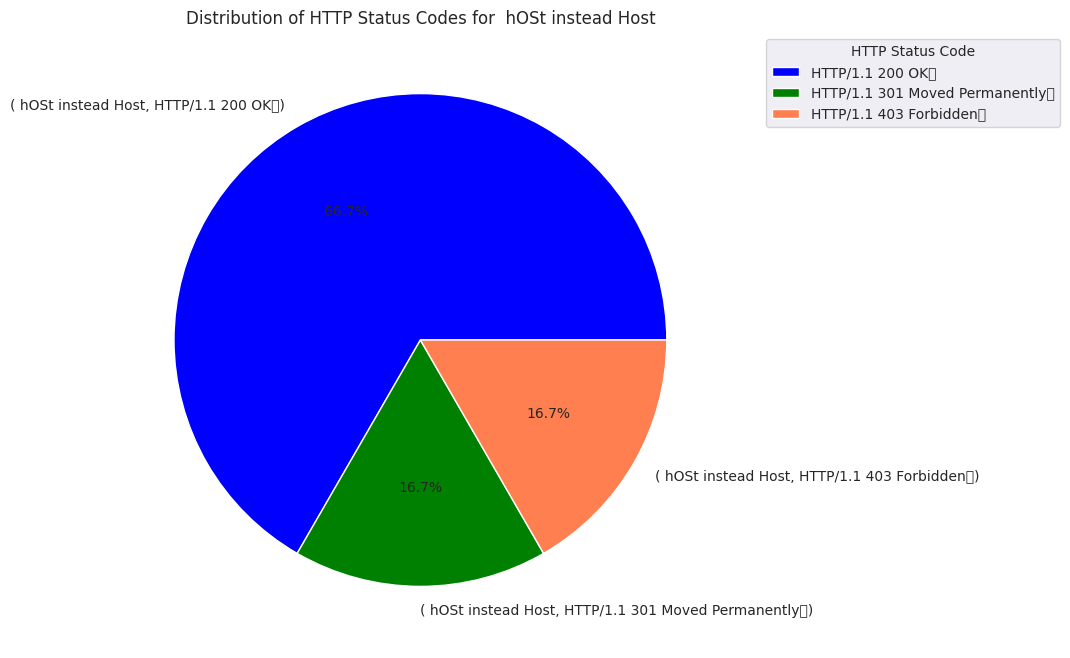

) missing from current font.hon3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


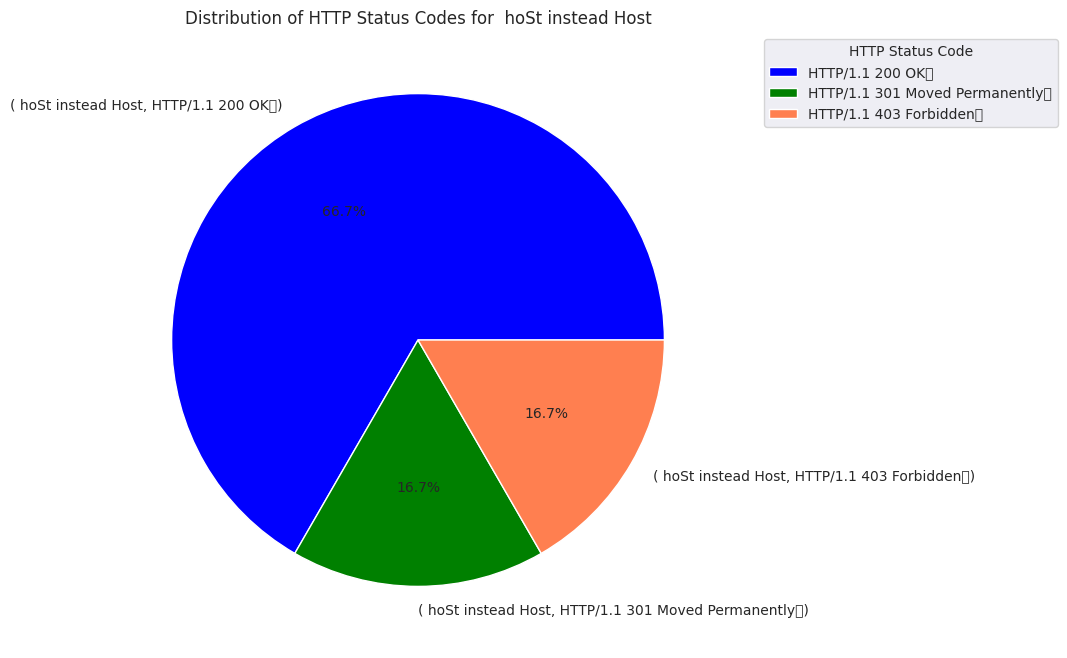

) missing from current font.hon3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


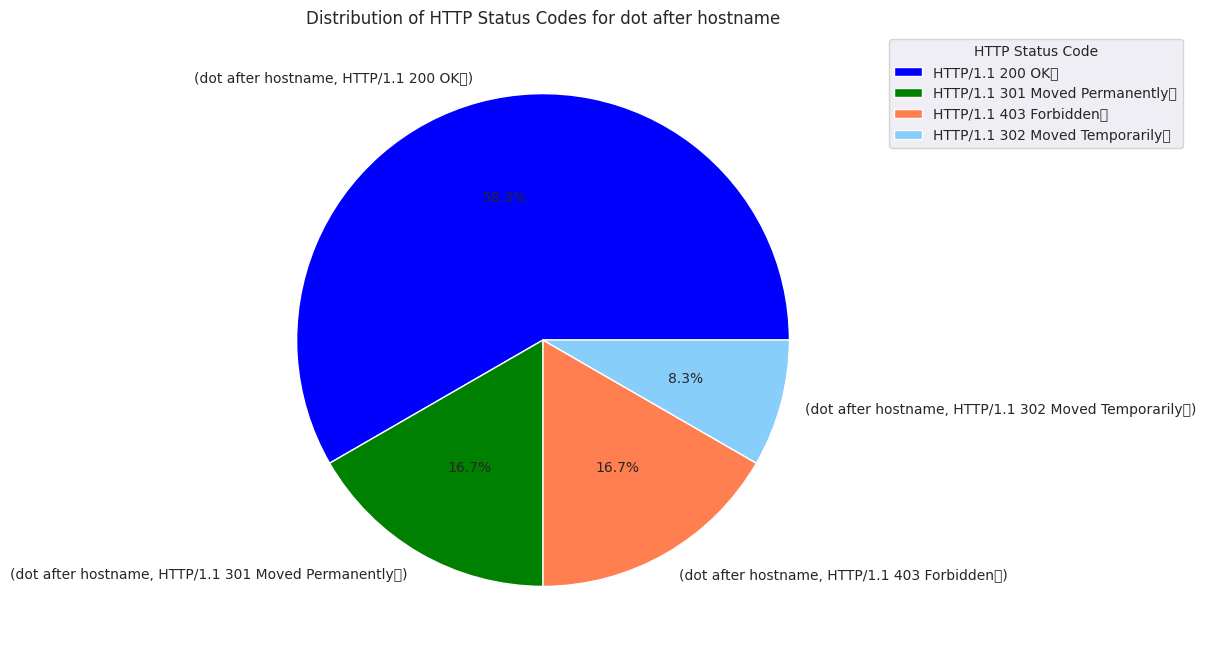

) missing from current font.hon3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


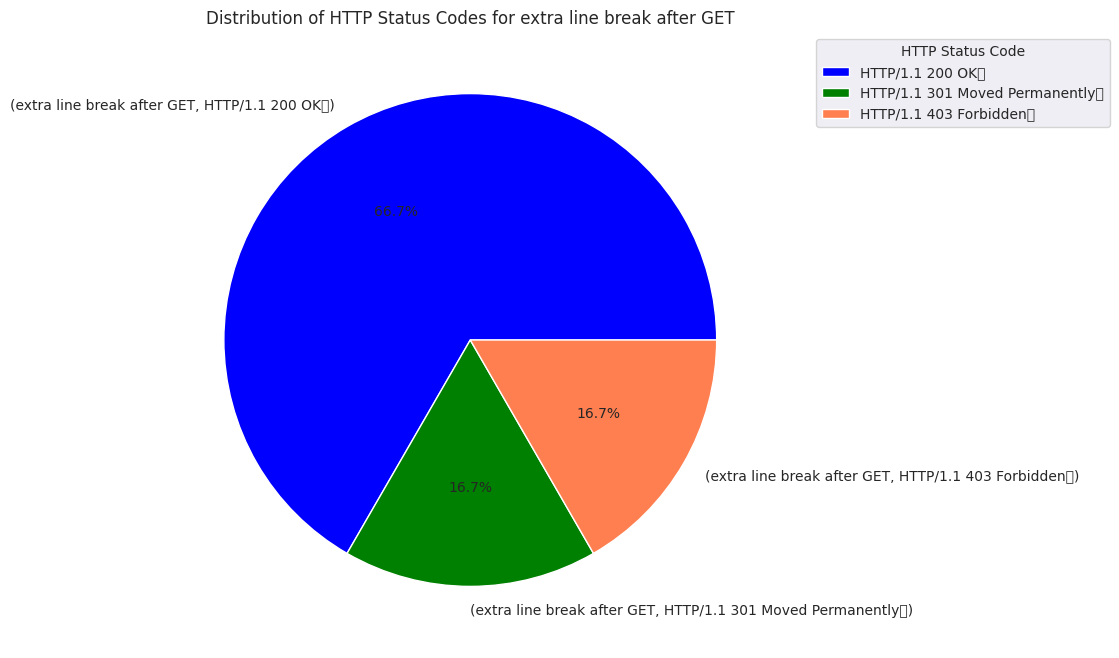

) missing from current font.hon3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


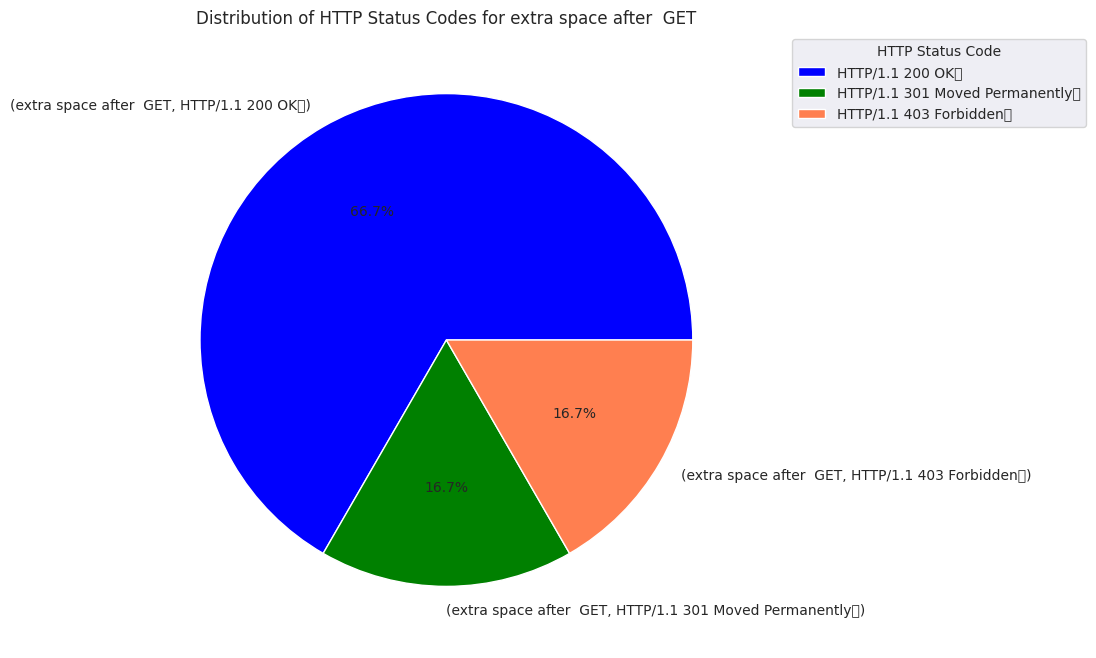

) missing from current font.hon3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


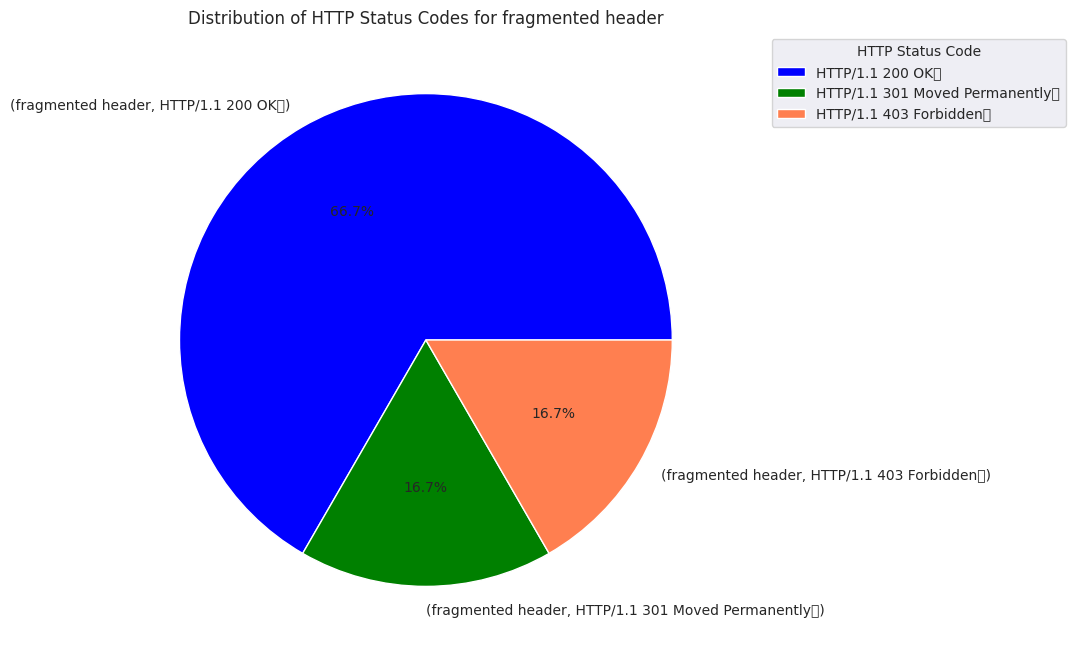

) missing from current font.hon3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


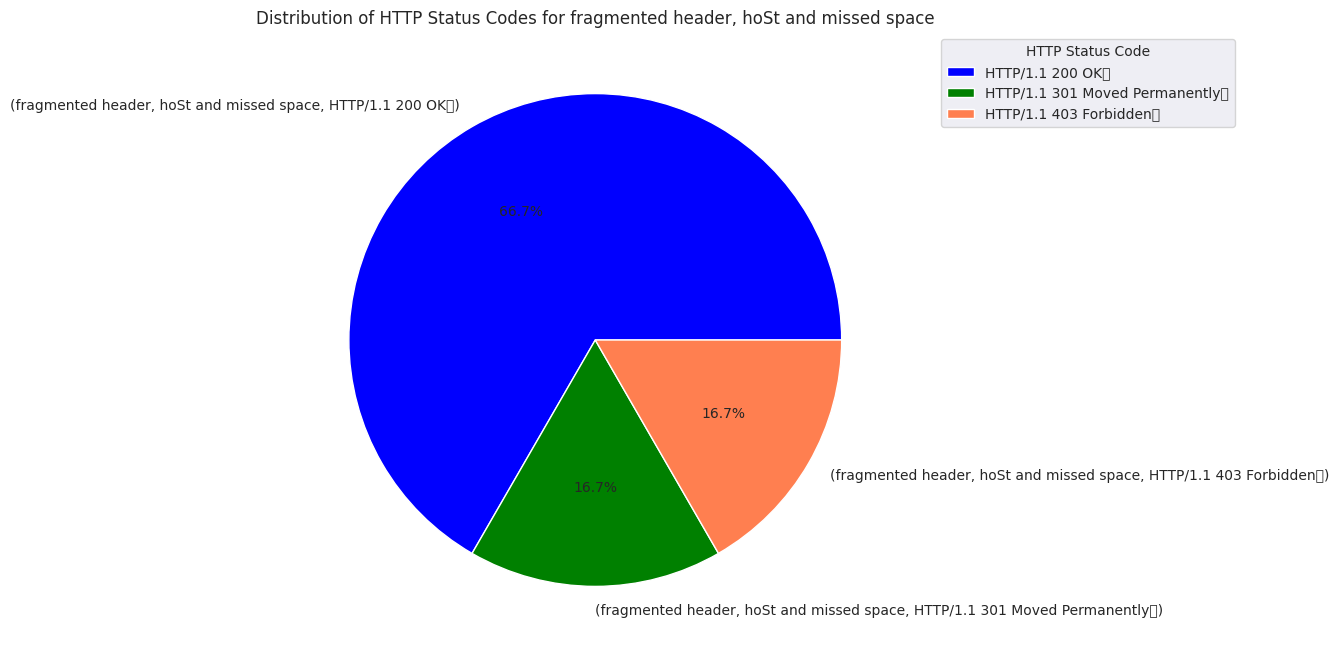

) missing from current font.hon3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


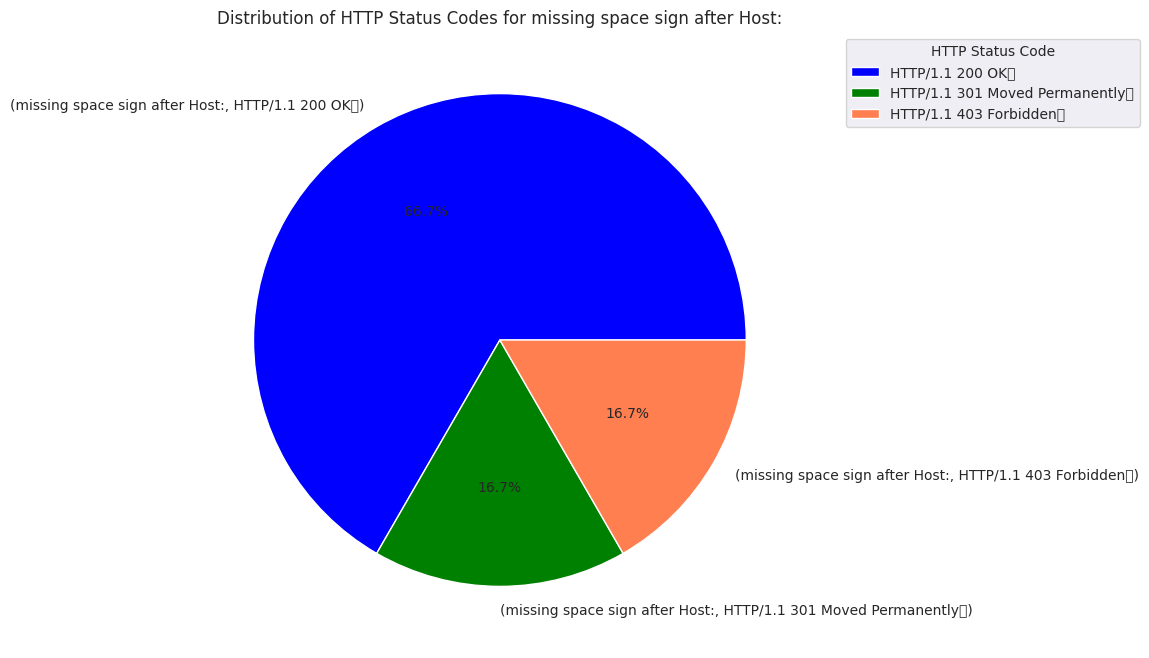

) missing from current font.hon3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


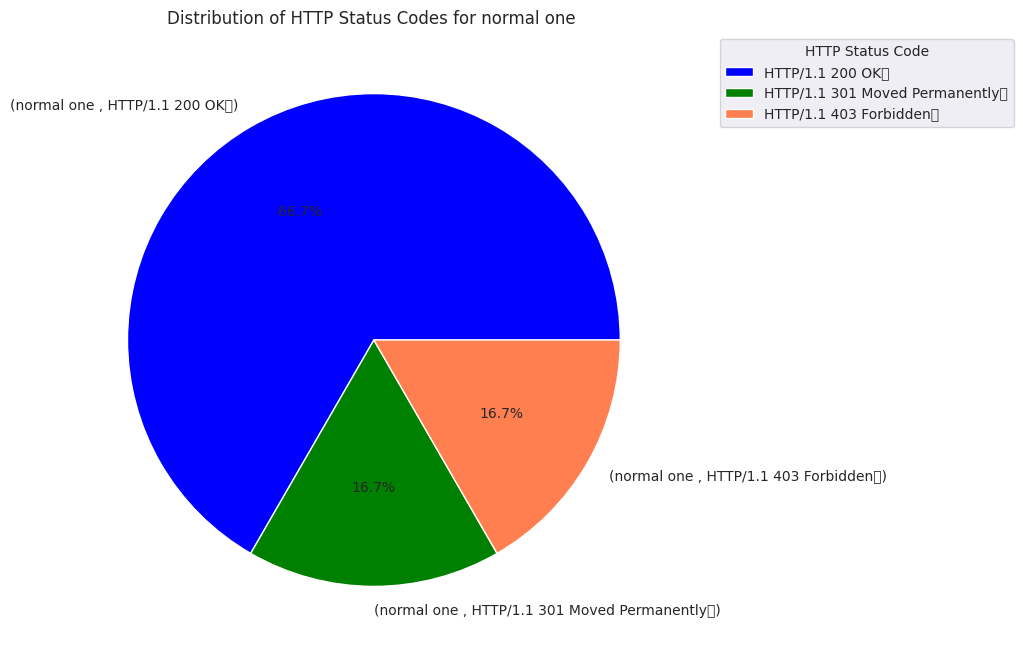

) missing from current font.hon3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


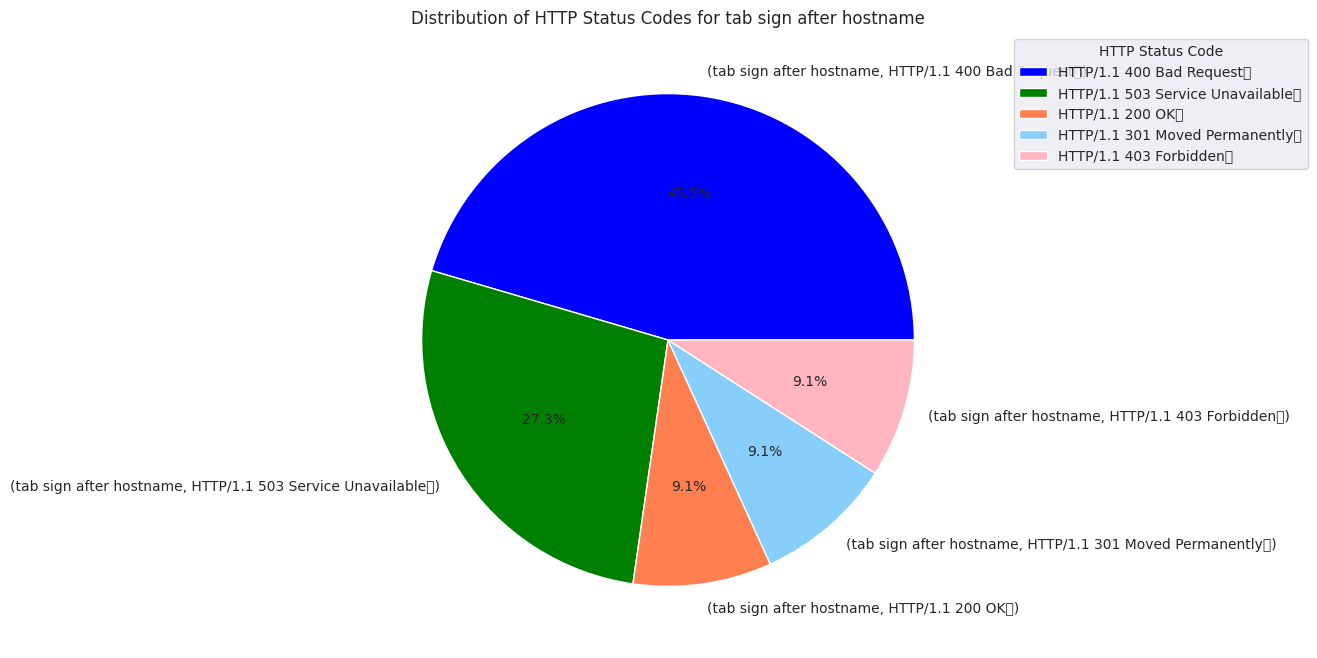

) missing from current font.hon3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


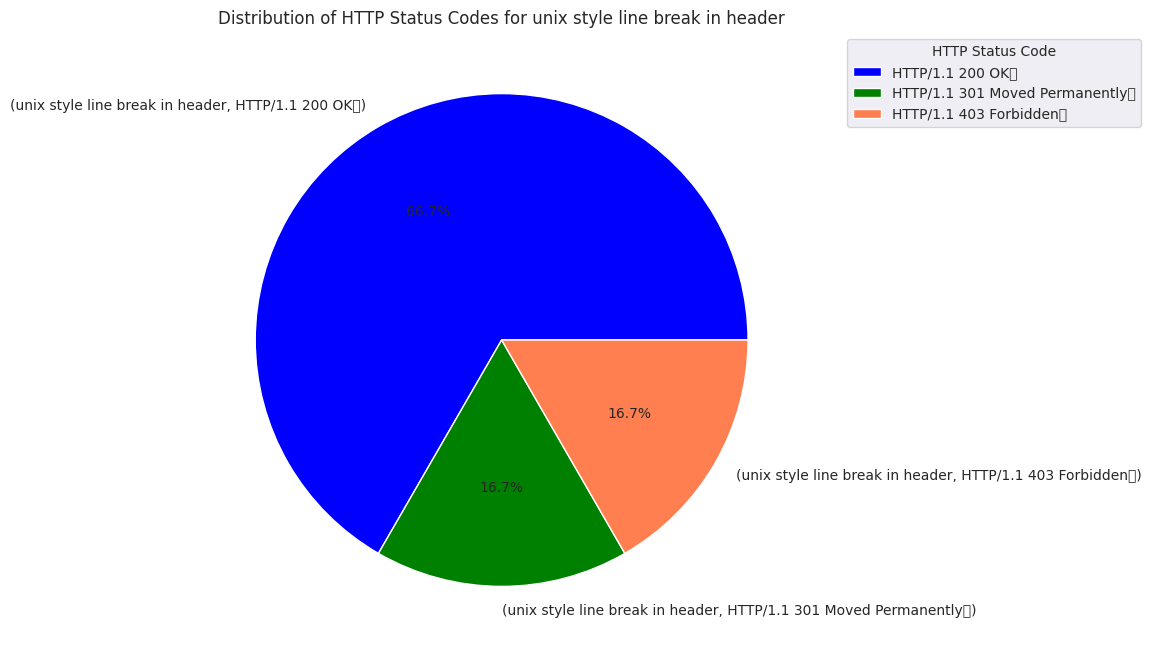

) missing from current font.hon3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


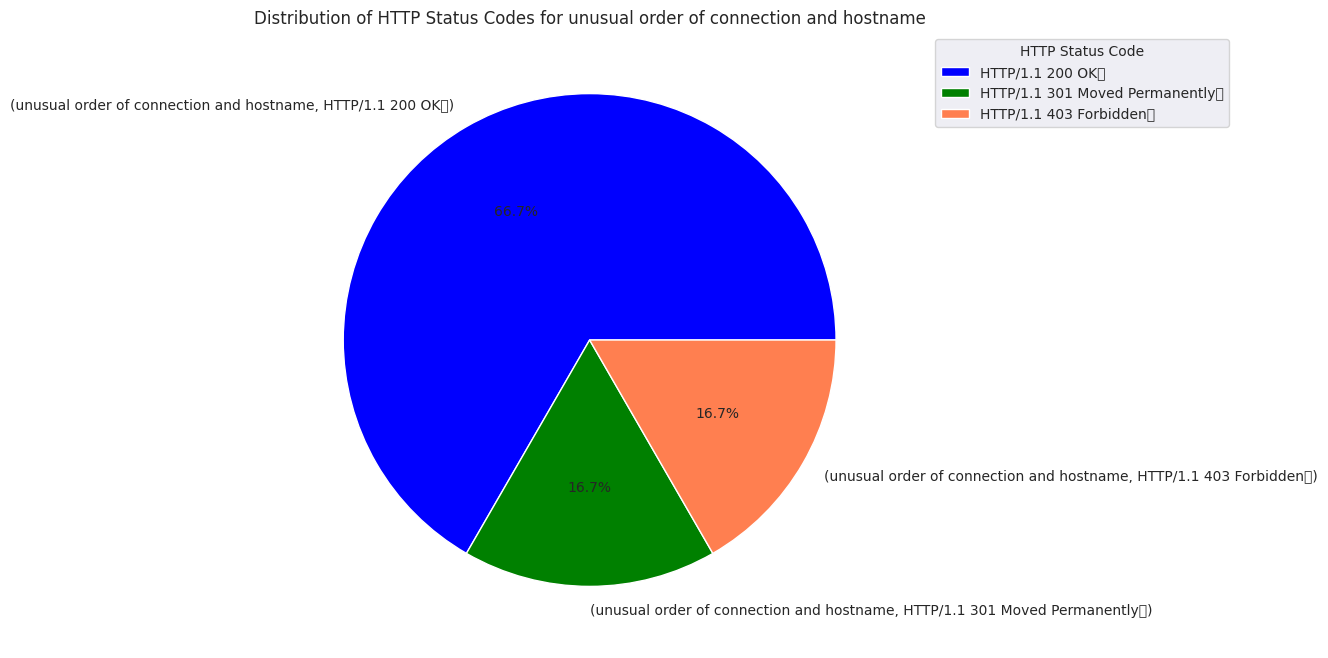

In [9]:
num_tests = len(top5_status_codes_names.index.unique())
rows = (num_tests + 2) // 3
cols = min(num_tests, 3)


for i, (test_name, data) in enumerate(top5_status_codes_names.groupby(level=0)):
    plt.figure(figsize=(8, 8))
    ax = data.plot(kind='pie', autopct='%1.1f%%', colors=['blue', 'green', 'coral', 'lightskyblue', 'lightpink'],)
    plt.legend(labels=data.index.get_level_values(1), title='HTTP Status Code', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.ylabel('')
    plt.title(f'Distribution of HTTP Status Codes for {test_name}')
    plt.show()

) missing from current font.hon3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


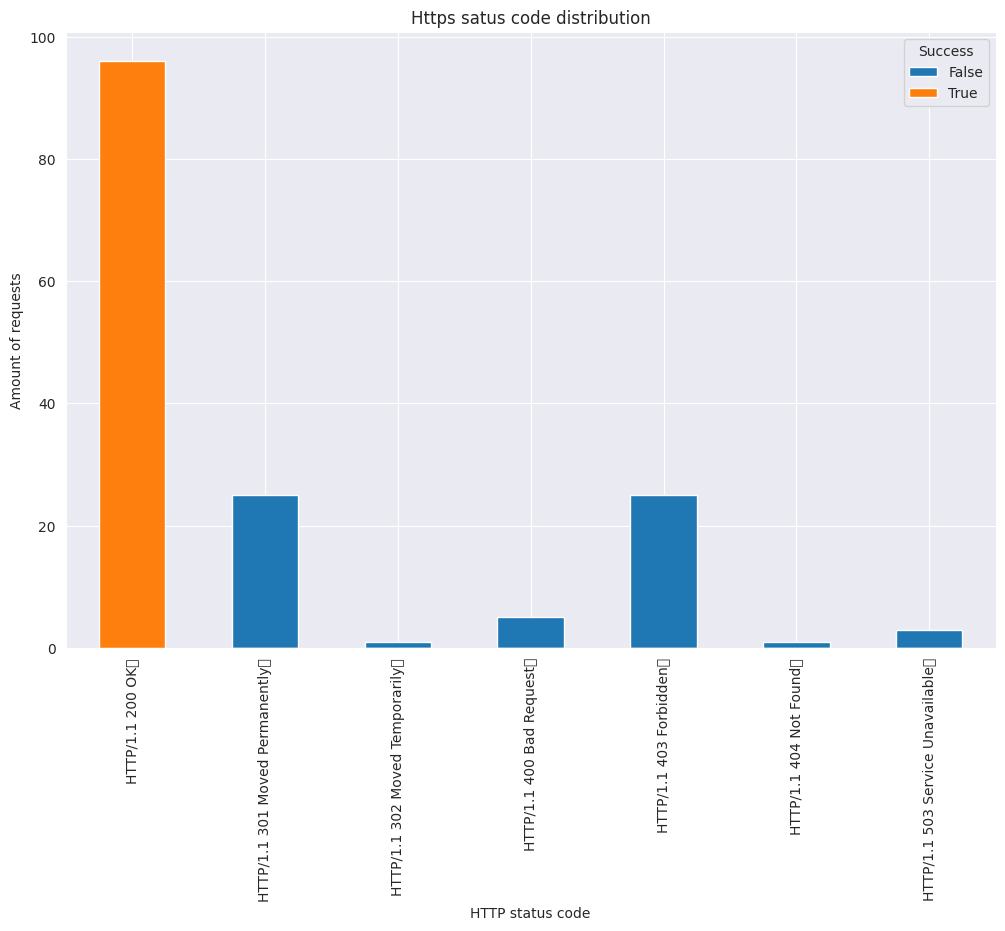

In [10]:
http_status_counts = df.groupby(['HTTP status code', 'Success']).size().unstack(fill_value=0)

http_status_counts.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Https satus code distribution')
plt.xlabel('HTTP status code')
plt.ylabel('Amount of requests')
plt.legend(title='Success', loc='upper right')
plt.show()
